In [11]:
using Optimization, OptimizationOptimJL, Plots
using ModelingToolkit, IntervalSets
using Sophon
using ChainRulesCore

@parameters t, x
@variables u(..), ρ(..), p(..)
Dₓ = Differential(x)
Dₜ = Differential(t)

u₀(x) = 0.0
ρ₀(x) = ifelse(x < 0.5, 1.0, 0.125)
@register ρ₀(x)
p₀(x) = ifelse(x < 0.5, 1.0, 0.1)
@register p₀(x)

bcs = [ρ(0, x) ~ ρ₀(x), u(0, x) ~ u₀(x), p(0, x) ~ p₀(x), u(t, 0) ~ 0.0, u(t, 1) ~ 0.0]

γ = 1.4
E(t, x) = p(t, x) / (γ - 1) + 0.5 * ρ(t, x) * abs2(u(t, x))

eqs = [
    Dₜ(ρ(t, x)) + Dₓ(ρ(t, x) * u(t, x)) ~ 0.0,
    Dₜ(ρ(t, x) * u(t, x)) + Dₓ(ρ(t, x) * u(t, x) * u(t, x) + p(t, x)) ~ 0.0,
    Dₜ(E(t, x)) + Dₓ(u(t, x) * (E(t, x) + p(t, x))) ~ 0.0,
]

t_min, t_max = 0.0, 0.2
x_min, x_max = 0.0, 1.0
domains = [t ∈ Interval(t_min, t_max), x ∈ Interval(x_min, x_max)]

@named pde_system = PDESystem(eqs, bcs, domains, [t, x], [u(t, x), ρ(t, x), p(t, x)])

PDESystem
Equations: Equation[Differential(x)(u(t, x)*ρ(t, x)) + Differential(t)(ρ(t, x)) ~ 0.0, Differential(x)((u(t, x)^2)*ρ(t, x) + p(t, x)) + Differential(t)(u(t, x)*ρ(t, x)) ~ 0.0, Differential(t)(2.5000000000000004p(t, x) + 0.5abs2(u(t, x))*ρ(t, x)) + Differential(x)((3.5000000000000004p(t, x) + 0.5abs2(u(t, x))*ρ(t, x))*u(t, x)) ~ 0.0]
Boundary Conditions: Equation[ρ(0, x) ~ ρ₀(x), u(0, x) ~ 0.0, p(0, x) ~ p₀(x), u(t, 0) ~ 0.0, u(t, 1) ~ 0.0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0..0.2), Symbolics.VarDomainPairing(x, 0.0..1.0)]
Dependent Variables: Num[u(t, x), ρ(t, x), p(t, x)]
Independent Variables: Num[t, x]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [12]:
pinn = PINN(u=FullyConnected(2, 1, tanh; num_layers=4, hidden_dims=16),
            ρ=FullyConnected(2, 1, tanh; num_layers=4, hidden_dims=16),
            p=FullyConnected(2, 1, tanh; num_layers=4, hidden_dims=16))

sampler = QuasiRandomSampler(1000, 400)

function pde_weights(phi, x, θ)
    ux = Sophon.finitediff(phi.u, x, θ.u, 1, 1)
    ρx = Sophon.finitediff(phi.ρ, x, θ.ρ, 1, 1)
    px = Sophon.finitediff(phi.p, x, θ.p, 1, 1)
    d = ux .+ ρx .+ px

    return ChainRulesCore.@ignore_derivatives inv.(0.2 .* abs.(d) .+ 1)
end

strategy = AdaptiveTraining(pde_weights, Returns(10))
prob = Sophon.discretize(pde_system, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(u = (layer_1 = (weight = [0.2797171473503113 -0.9226866364479065; -0.8181580305099487 -1.356592059135437; … ; 0.12920136749744415 1.4037435054779053; 1.8126484155654907 -1.268056035041809], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [-0.5729383826255798 0.17881667613983154 … 0.42145371437072754 -0.6241165399551392; 0.47872021794319153 -0.3584308624267578 … 0.2783614993095398 -0.015695486217737198; … ; -0.3528910279273987 0.2743287682533264 … 0.7089507579803467 -0.5693845152854919; 0.2732207477092743 0.004746293183416128 … -0.06916610896587372 0.2520962357521057], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [-0.6413446068763733 0.6340323686599731 … 0.4845469892024994 0.7132672667503357; -0.5663682222366333 0.5640870928764343 … -0.0027979291044175625 -0.3649193048477173; … ; -0.4733128547668457 -0.09491502493619919 … -0.023376842960715294 -0.4534431993961334; 0.5198674201965332 0.1795347034931183 … 

In [13]:
res = Optimization.solve(prob, BFGS(); maxiters=1000)
res.objective

0.0002402560344178273

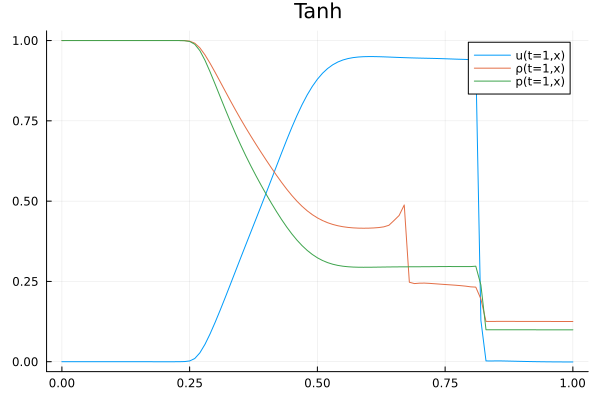

In [14]:
using Plots
θ = res.u
phi = pinn.phi
xs = x_min:0.01:x_max |> collect

phi = pinn.phi
p1 = plot(xs, [first(phi.u([t_max, x], θ.u)) for x in xs]; label="u(t=1,x)")
p2 = plot!(xs, [first(phi.ρ([t_max, x], θ.ρ)) for x in xs]; label="ρ(t=1,x)")
p3 = plot!(xs, [first(phi.p([t_max, x], θ.p)) for x in xs]; label="p(t=1,x)")
title!("Tanh")

## Softplut

In [15]:
using NNlib

pinn = PINN(u=FullyConnected(2, 1, softplus; num_layers=4, hidden_dims=16),
            ρ=FullyConnected(2, 1, softplus; num_layers=4, hidden_dims=16),
            p=FullyConnected(2, 1, softplus; num_layers=4, hidden_dims=16))
prob = Sophon.discretize(pde_system, pinn, sampler, strategy)
res = Optimization.solve(prob, BFGS(); maxiters=1000)
res.objective

In [ ]:
θ = res.u
phi = pinn.phi
xs = x_min:0.01:x_max |> collect

phi = pinn.phi
p1 = plot(xs, [first(phi.u([t_max, x], θ.u)) for x in xs]; label="u(t=1,x)")
p2 = plot!(xs, [first(phi.ρ([t_max, x], θ.ρ)) for x in xs]; label="ρ(t=1,x)")
p3 = plot!(xs, [first(phi.p([t_max, x], θ.p)) for x in xs]; label="p(t=1,x)")
title!("Softplus")

## Stan

In [ ]:
pinn = PINN(u=FullyConnected(2, 1, stan; num_layers=4, hidden_dims=16),
            ρ=FullyConnected(2, 1, stan; num_layers=4, hidden_dims=16),
            p=FullyConnected(2, 1, stan; num_layers=4, hidden_dims=16))
prob = Sophon.discretize(pde_system, pinn, sampler, strategy)
res = Optimization.solve(prob, BFGS(); maxiters=1000)
res.objective

In [ ]:
θ = res.u
phi = pinn.phi
xs = x_min:0.01:x_max |> collect

phi = pinn.phi
p1 = plot(xs, [first(phi.u([t_max, x], θ.u)) for x in xs]; label="u(t=1,x)")
p2 = plot!(xs, [first(phi.ρ([t_max, x], θ.ρ)) for x in xs]; label="ρ(t=1,x)")
p3 = plot!(xs, [first(phi.p([t_max, x], θ.p)) for x in xs]; label="p(t=1,x)")
title!("Softplus")